[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/image-retrieval/cnn/cifar10.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/image-retrieval/cnn/cifar10.ipynb)

### Generate Image Embeddings Using CNNs

In this section, we will use PyTorch to build a Convolutional Neural Network from scratch  that generates image embeddings.✔✔✔

In [1]:
# Connect to a Cloud TPU which more powerfuls than a GPU
# Make sure to select TPU from Edit > Notebook settings > Hardware accelerator
import os
assert os.environ['COLAB_TPU_ADDR']

# Installing PyTorch/XLA
The PyTorch/XLA package lets PyTorch connect to Cloud TPUs. (It's named PyTorch/XLA, not PyTorch/TPU, because XLA is the name of the TPU compiler.) In particular, PyTorch/XLA makes TPU cores available as PyTorch devices. This lets PyTorch create and manipulate tensors on TPUs.

In [2]:
!pip install cloud-tpu-client==0.10 torch==2.0.0 torchvision==0.15.1 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-2.0-cp310-cp310-linux_x86_64.whl

## Creating and Manipulating Tensors on TPUs

PyTorch uses Cloud TPUs just like it uses CPU or CUDA devices, as the next few cells will show. Each core of a Cloud TPU is treated as a different PyTorch  device.

In [3]:
# imports pytorch
import torch

# imports the torch_xla package
import torch_xla
import torch_xla.core.xla_model as xm

# Creates a random tensor on xla:1 (a Cloud TPU core)
device = xm.xla_device()

#### Data Initialization

Before starting, below are some libraries we would need to build the convolutional network.

In [4]:
# Load in relevant libraries, and alias where appropriate
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

Given we will be working with a reasonable amount of data, we might want to process it on GPU rather than CPU. To do that, we need to transfer the data from CPU to GPU using ```torch.device```.

In [6]:
# Device will determine whether to run the training on GPU or CPU.
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The first step in building our network is downloading and initializing the dataset.

The dataset we are downloading is *CIFAR-10* from HuggingFace.

We will first download the training dataset by setting ```split = 'train'```, and the testing dataset after by setting ''split = 'test'```. While the training dataset includes 50,000 images divided into 10 classes, the test dataset includes 10,000 images divided into 10 classes.

In [ ]:
# Install datasets library
!pip install datasets

In [6]:
# import CIFAR-10 dataset from HuggingFace
from datasets import load_dataset

dataset_train = load_dataset(
    'cifar10',
    split='train[:10%]', # 10% training dataset
    # split='train', # training dataset
    ignore_verifications=True  # set to True if seeing splits Error
)

dataset_train

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4. Subsequent calls will reuse this data.


Dataset({
    features: ['img', 'label'],
    num_rows: 5000
})

In [7]:
# check how many labels/number of classes
num_classes = len(set(dataset_train['label']))
num_classes

10

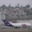

In [10]:
# let's view the image (it's very small)
dataset_train[0]['img']

In [11]:
type(dataset_train[0]['img'])

PIL.PngImagePlugin.PngImageFile

Now pull in the test set (that we will use as a validation set).

In [12]:
dataset_val = load_dataset(
    'cifar10',
    split='test[:10%]', # 10% test dataset
    # split='test', # test dataset
    ignore_verifications=True  # set to True if seeing splits Error
)

dataset_val

Dataset({
    features: ['img', 'label'],
    num_rows: 1000
})

Most convolutional neural networks are designed so that they can only accept images of a fixed size. It's common practice to overcome this by reshaping the input images.

We chose to reshape the image to 32 pixels - see ```img_size```.

In addition, PyTorch uses tensors.

Therefore, we will transform the data using the ```transforms.Compose``` method, and save the reshaped tensors in the ```preprocess``` variable.

In [13]:
# image size
img_size = 32

# preprocess variable, to be used ahead
preprocess = transforms.Compose([
    transforms.Resize((img_size,img_size)),
    transforms.ToTensor()
])

We can now use the ```preprocess``` variable on the dataset with the following loop. However, when we build a cnn, we should ensure every image has the same number of input channels (or depth). This is because the input dimension to the cnn cannot change.

If we have RGB images, the depth will be $3$, with one channel for each color (red, green, and blue). If we have grayscale images, the depth will be $1$.

In case the dataset contains images with different number of channels, we should convert them from grayscale to RGB (or the other way round). When an image is in grayscale, its ```mode``` is `L`. Otherwise, the mode is `RGB`.

We then converted the images to RGB and preprocessed them in the same loop.

In [14]:
from tqdm.auto import tqdm

inputs_train = []

for record in tqdm(dataset_train):
    image = record['img']
    label = record['label']

    # convert from grayscale to RGB
    if image.mode == 'L':
        image = image.convert("RGB")

    # prepocessing
    input_tensor = preprocess(image)

    # append to batch list
    inputs_train.append([input_tensor, label])

  0%|          | 0/50000 [00:00<?, ?it/s]

In [15]:
print(len(inputs_train), inputs_train[0][0].shape)

50000 torch.Size([3, 32, 32])


Below we can see the result from the transformation.

In [16]:
inputs_train[0]

[tensor([[[0.6980, 0.6980, 0.6980,  ..., 0.6667, 0.6588, 0.6471],
          [0.7059, 0.7020, 0.7059,  ..., 0.6784, 0.6706, 0.6588],
          [0.6941, 0.6941, 0.6980,  ..., 0.6706, 0.6627, 0.6549],
          ...,
          [0.4392, 0.4431, 0.4471,  ..., 0.3922, 0.3843, 0.3961],
          [0.4392, 0.4392, 0.4431,  ..., 0.4000, 0.4000, 0.4000],
          [0.4039, 0.3922, 0.4039,  ..., 0.3608, 0.3647, 0.3569]],
 
         [[0.6902, 0.6902, 0.6902,  ..., 0.6588, 0.6510, 0.6392],
          [0.6980, 0.6941, 0.6980,  ..., 0.6706, 0.6627, 0.6510],
          [0.6863, 0.6863, 0.6902,  ..., 0.6627, 0.6549, 0.6471],
          ...,
          [0.4196, 0.4275, 0.4314,  ..., 0.3804, 0.3686, 0.3725],
          [0.4000, 0.4039, 0.4039,  ..., 0.3725, 0.3647, 0.3608],
          [0.3765, 0.3647, 0.3725,  ..., 0.3294, 0.3373, 0.3294]],
 
         [[0.7412, 0.7412, 0.7412,  ..., 0.7059, 0.6941, 0.6824],
          [0.7490, 0.7451, 0.7490,  ..., 0.7137, 0.7059, 0.6941],
          [0.7373, 0.7373, 0.7412,  ...,

The tensors are normalized to a \[0, 1\] range by the `preprocess` pipeline thanks to the `transforms.ToTensor()` function. We need to modify this normalization slightly to fit this specific dataset. To do this, we need the mean and standard deviation values for each of the RGB channels across all images.

We calculate that like so:

In [17]:
import numpy as np

np.random.seed(0)

# calculate mean and std of images, first start by choosing a random sample of tensors
idx = np.random.randint(0, len(inputs_train), 512)
idx.shape

(512,)

In [18]:
# then we concatenate this subset of image tensors
tensors = torch.concat([inputs_train[i][0] for i in idx], axis=1)
tensors.shape

torch.Size([3, 16384, 32])

In [19]:
# merge all values into single 3-channel vector
tensors = tensors.swapaxes(0, 1).reshape(3, -1).T
tensors.shape

torch.Size([524288, 3])

In [20]:
mean = torch.mean(tensors, axis=0)
mean

tensor([0.4670, 0.4735, 0.4662])

In [21]:
std = torch.std(tensors, axis=0)
std

tensor([0.2496, 0.2489, 0.2521])

In [22]:
del tensors

Now we use the `mean` $[0.4670, 0.4735, 0.4662]$ and `std` $[0.2496, 0.2489, 0.2521]$ to normalize via another preprocessing step.

In [23]:
preprocess = transforms.Compose([transforms.Normalize(mean=mean, std=std)])

for i in tqdm(range(len(inputs_train))):
    # prepocessing
    input_tensor = preprocess(inputs_train[i][0])
    inputs_train[i][0] = input_tensor  # replace with normalized tensor

  0%|          | 0/50000 [00:00<?, ?it/s]

We can merge the preprocessing steps as follows,

In [24]:
# merge the two preprocessing steps from before
preprocess = transforms.Compose([
    transforms.Resize((img_size,img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

and we can apply the same transformation to the validation set.

In [25]:
from tqdm.auto import tqdm

inputs_val = []
i = 0
for record in tqdm(dataset_val):
    image = record['img']
    label = record['label']

    # convert from grayscale to RBG
    if image.mode == 'L':
        image = image.convert("RGB")

    # prepocessing
    input_tensor = preprocess(image)
    inputs_val.append((input_tensor, label)) # append to batch list

  0%|          | 0/10000 [00:00<?, ?it/s]

Given the amount of data, we would improve the efficiency of our model by running it in batches. We can set the batch size to $64$.

In [26]:
# define batch size
batch_size = 64

We can then use ```DataLoader``` to split both the training and validation dataset into shuffled batches. Shuffle helps prevent model overfitting by ensuring that batches are more representative of the entire dataset.

In [27]:
dloader_train = torch.utils.data.DataLoader(
    inputs_train, batch_size=batch_size, shuffle=True
)

In [28]:
dloader_val = torch.utils.data.DataLoader(
    inputs_val, batch_size=batch_size, shuffle=False
)

#### Building the CNN's Structure/Architecture

We can now start building our cnn by generating the `ConvNeuralNet` class and the `forward` function. The `ConvNeuralNet` class defines the elements inside our network. The `forward` function establishes their order:

- The first two blocks of layers are composed of a convolutional layer followed by a max-pooling layer. After each convolutional layer, we added non-linearity using the ReLU activation function.

- The following two blocks of layers are composed of a convolutional layer followed by the ReLU activation function.

- We then have another block composed of one convolutional layer, followed by the ReLU, followed by the max pooling layer.

At each block, the images are downsampled by the max-pooling layer. Contrary, the number of channels from one layer to another increased from $3$ to $64$, to $192$, ..., to $256$. As we learned before, deeper layers have larger receptive fields and generally detect more specific and complex features, such as ears, eyes, or even human faces and dogs. The chosen filter (or kernel) size is either $3$ or $4$. This is a common choice - having a smaller filter allows the network to better generalize. Padding is $1$ pixel on each layer.

- In the end, we have three fully-connected layers. The first two are activated using the ReLU, and the last one uses the Softmax.

Note that we added `dropout`. It randomly zeroes (or "drops out") some of the elements of the input tensor with a probability $p = 25\%$. This has proven to be an effective technique for regularization and preventing the co-adaptation of neurons as described in the paper Improving neural networks by preventing co-adaptation of feature detectors [1].


We can represent our network as follows:

[image]

In [29]:
# creating a CNN class
class ConvNeuralNet(nn.Module):
	#  determine what layers and their order in CNN object
    def __init__(self, num_classes):
        super(ConvNeuralNet, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, padding=1)
        self.relu1 = nn.ReLU()
        self.max_pool1 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv_layer2 = nn.Conv2d(in_channels=64, out_channels=192, kernel_size=4, padding=1)
        self.relu2 = nn.ReLU()
        self.max_pool2 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv_layer3 = nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()

        self.conv_layer4 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1)
        self.relu4 = nn.ReLU()

        self.conv_layer5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.relu5 = nn.ReLU()
        self.max_pool5 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.dropout6 = nn.Dropout(p=0.5)
        self.fc6 = nn.Linear(1024, 512)
        self.relu6 = nn.ReLU()
        self.dropout7 = nn.Dropout(p=0.5)
        self.fc7 = nn.Linear(512, 256)
        self.relu7 = nn.ReLU()
        self.fc8 = nn.Linear(256, num_classes)

    # progresses data across layers
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.relu1(out)
        out = self.max_pool1(out)

        out = self.conv_layer2(out)
        out = self.relu2(out)
        out = self.max_pool2(out)

        out = self.conv_layer3(out)
        out = self.relu3(out)

        out = self.conv_layer4(out)
        out = self.relu4(out)

        out = self.conv_layer5(out)
        out = self.relu5(out)
        out = self.max_pool5(out)

        out = out.reshape(out.size(0), -1)

        out = self.dropout6(out)
        out = self.fc6(out)
        out = self.relu6(out)

        out = self.dropout7(out)
        out = self.fc7(out)
        out = self.relu7(out)

        out = self.fc8(out)  # final logits
        return out

After setting the architecture of our network, we can define the loss function, which is calculated after the forward propagation. We will then define the optimization methodology to run the backpropagation.

The loss function used is cross-entropy.

The model optimization is run using the stochastic gradient descent (SGD) method with a learning rate equal to $0.008$. Training under SGD, the network is forced to learn to extract features from the image that minimize the loss for extracting features that are the most useful for classifying or recognising images.
The learning rate can be chosen randomly by running the model using different values and selecting the one that gives the best performance.

In [30]:
# set the model to device
model = ConvNeuralNet(num_classes).to(device)

# set Loss function with criterion
loss_func = nn.CrossEntropyLoss()

# set learning rate
lr = 0.008  # 0.0001

# set optimizer with optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
#total_step = len(dloader)

We are now ready to train our model with the forward and the backward propagation in batches. We are now using the `device` variable created above to move the data to GPU, if possible.

We have set the times the learning algorithm will work through the entire training dataset (epochs) to 50. As per the learning rate, there is no rule for choosing this value. You can run the model many times with different values and choose the one with the sufficiently minimized error.

It is also essential to not choose a number of `epochs` (or `lr`) that causes the model to overfit the training set. To check this, we include a pass through the validation set after each epoch, calculating the val-loss and val-accuracy. If we see the validation set performance degrades while train loss decreases, the model is likely overfitting.

In [ ]:
# train and validate the network
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
	# load in the data in batches
    for i, (images, labels) in enumerate(dloader_train):
        # move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # forward propagation
        outputs = model(images)
        loss = loss_func(outputs, labels)

        # backward propagation and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # at end of epoch check validation loss and accuracy on validation set
    with torch.no_grad():
        model.eval()
        correct = 0
        total = 0
        all_val_loss = []
        for images, labels in dloader_val:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            total += labels.size(0)
            # calculate predictions
            predicted = torch.argmax(outputs, dim=1)
            # calculate actual values
            correct += (predicted == labels).sum().item()
            # calculate the loss
            all_val_loss.append(loss_func(outputs, labels).item())
        # calculate val-loss
        mean_val_loss = sum(all_val_loss) / len(all_val_loss)
        # calculate val-accuracy
        mean_val_acc = 100 * (correct / total)

    print(
        'Epoch [{}/{}], Loss: {:.4f}, Val-loss: {:.4f}, Val-acc: {:.1f}%'.format(
            epoch+1, num_epochs, loss.item(), mean_val_loss, mean_val_acc
        )
    )

The network is now trained and tested! The network validation accuracy is $79.4\%$. We can go ahead and save the model to file.

In [ ]:
torch.save(model, 'cnn.pt')

---

# Inference

Now we will look at how to make predictions with the model. We start by loading the model from file:

In [ ]:
import torch

model = torch.load('cnn.pt')
# switch to evaluation mode and device
model.eval().to(device)
print(device)

We will reinitialize the CIFAR-10 test set to similate a typical scenario where we would need to reload everything. Ideally we would not use the validation set as a test set.

In [ ]:
# import CIFAR-10 dataset from HuggingFace
from datasets import load_dataset

data_test = load_dataset(
    'cifar10',
    split='test'  # test set
)
data_test

In [ ]:
input_tensors = []
for image in data_test['img'][:10]:
    tensor = preprocess(image)
    input_tensors.append(tensor.to(device))

In [ ]:
# we have 10 tensors
len(input_tensors)

In [ ]:
# all 32x32 dimensional with 3 color channels
input_tensors[0].shape

We stack these into a single tensor.

In [ ]:
# stack into a single tensor
input_tensors = torch.stack(input_tensors)
input_tensors.shape

In [ ]:
# process through model to get output logits
outputs = model(input_tensors)
# calculate predictions
predicted = torch.argmax(outputs, dim=1)
predicted

In [ ]:
predicted.shape

In [ ]:
# here are the class names
data_test.features['label'].names

In [ ]:
data_test[1]['label']

In [ ]:
import matplotlib.pyplot as plt

for i, image in enumerate(data_test['img'][:10]):
    plt.imshow(image)
    plt.show()
    print(data_test.features['label'].names[predicted[i]])

Most of these predictions look correct, despite being very low resolution images.

---